# Training Denoisers with Noise Texture Augmentation

The goal of this notebook is to introduce the noise texture augmentation loop previously introduced in [00_characterizing_noise_augmentation.ipynb](00_characterizing_noise_augmentation.ipynb) as well as provides a mean for selecting the $\lambda$ parameter controlling the amount of data augmentation.

![augmented training](figures/fig1b_augmented.png)
*Figure 1b In noise texture augmented training noise patches are added to the low noise training target to make new augmented inputs. While training, a proportion λ of the training data mini batch is from the augmented inputs while the remaining 1 − λ is from the original low dose training inputs.*

If reproducing these figures on your own local dataset, replace `base_dir` with your download location of the dataset available for download at [Zenodo](https://zenodo.org/doi/10.5281/zenodo.10064035)

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.11267694.svg)](https://doi.org/10.5281/zenodo.11267694)

These phantom simulations were generated using the [pediatricIQphantoms](https://github.com/DIDSR/pediatricIQphantoms), please see the associated [documentation](https://pediatriciqphantoms.readthedocs.io/en/latest/?badge=latest) on how to rerun the simulations under different imaging conditions.

In [1]:
from pathlib import Path

ldgc_path = Path('../data/Mayo_LDGC') # training dataset

peds_datadir = Path('../data/pediatricIQphantoms') # testing dataset
anthro_datadir = Path('../data/anthropomorphic') # testing dataset

if not ldgc_path.exists():
    raise RuntimeError(f'Low Dose Grand Challenge Dataset not found in {ldgc_path}, please download here: <https://aapm.app.box.com/s/eaw4jddb53keg1bptavvvd1sf4x3pe9h/folder/145241244881>')

from torchvision.datasets.utils import download_and_extract_archive
if not peds_datadir.exists():
    download_and_extract_archive(url='https://zenodo.org/records/11267694/files/pediatricIQphantoms.zip', download_root=peds_datadir.parent)

if not anthro_datadir.exists():
    download_and_extract_archive(url='https://zenodo.org/records/12538350/files/anthropomorphic.zip', download_root=anthro_datadir.parent)

In [2]:
import os
import sys
sys.path.append('..')
from denoising.loader import get_loader
import torch
from denoising.networks import RED_CNN

def read_dicom(dcm_file):
    dcm = pydicom.read_file(dcm_file)
    return dcm.pixel_array + float(dcm.RescaleIntercept)

def load_model(save_path, iter_=13000, device='cpu'):
    REDCNN = RED_CNN()
    f = os.path.join(save_path, 'REDCNN_{}iter.ckpt'.format(iter_))
    REDCNN.load_state_dict(torch.load(f, map_location=device))
    return REDCNN

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
denoising_model  = load_model('../denoising/models/redcnn', device=device)

/home/brandon.nelson/Dev/PediatricCTSizeAugmentation/.data_aug_torch/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


If interested in retraining models, the Mayo Clinic Low Dose Grand Challenge (LDGC) dataset is available for download from the Cancer Imaging Archive: [https://doi.org/10.7937/9npb-2637](https://www.cancerimagingarchive.net/collection/ldct-and-projection-data/) for more information on the dataset please see [CTCIC/patient-ct-projection-data-library](https://ctcicblog.mayo.edu/patient-ct-projection-data-library/)

In [3]:
from subprocess import run
model_path = Path('models')

if model_path.exists():
    for lmbda in range(11):
        lmbda/=10
        model_path = Path(f'models/lambda{int(lmbda*100):03d}')
        model = load_model(model_path)
        print(model_path)
else:
    for lmbda in range(11):
        lmbda/=10
        run(['python', '../../denoising/main.py',
             '--data_path' ,f'{ldgc_path}/images',
             '--saved_path', f'{ldgc_path}/numpy_files',
             '--load_mode', '1',
             '--save_path', f'models/lambda{int(lmbda*100):03d}',
             '--augment', f'{lmbda}'])

models/lambda000
models/lambda010
models/lambda020
models/lambda030
models/lambda040
models/lambda050
models/lambda060
models/lambda070
models/lambda080
models/lambda090
models/lambda100


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import SimpleITK as sitk

meta = pd.read_csv(peds_datadir / 'metadata.csv')
# meta.file = meta.file.apply(lambda o: peds_datadir / o)
meta = meta[meta.recon == 'fbp']
meta.rename(columns={'repeat':'instance'}, inplace=True)

anthro_meta =  pd.read_csv(anthro_datadir / 'metadata.csv')
anthro_meta.file = anthro_meta.file.apply(lambda o: anthro_datadir / o)
anthro_meta = anthro_meta[anthro_meta.recon == 'fbp']
anthro_meta.studyid = anthro_meta.studyid + 1 + meta.studyid.max()
meta = pd.concat([meta, anthro_meta], ignore_index=True)

meta.head()

,Name,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],...,instance,Unnamed: 0,Code #,gender,weight [kg],height [cm],BMI,weight percentile,ethnicity,simulated
0,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,25.0,fbp,D45,12.3,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,25.0,fbp,D45,12.3,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,25.0,fbp,D45,12.3,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,25.0,fbp,D45,12.3,...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,25.0,fbp,D45,12.3,...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
meta.studyid.unique()

array([  0,   3,   6,   9,  12,  15,  18,  21,  24,  27,  30,  33,  36,
        39,  42,  45,  48,  51,  54,  57,  60,  63,  66,  69,  72,  75,
        78,  81,  84,  87,  90,  93,  96,  99, 102, 105, 108, 111, 114,
       117, 120, 123, 126, 129, 132, 135, 138, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181])

This the lower studyids are the iq phantoms, the upper are anthropomorphic

In [6]:
anthro_meta.studyid.unique()

array([142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181])

In [7]:
meta[meta.studyid == 3]

,Name,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],...,instance,Unnamed: 0,Code #,gender,weight [kg],height [cm],BMI,weight percentile,ethnicity,simulated
19,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,100.0,fbp,D45,12.3,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,100.0,fbp,D45,12.3,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,100.0,fbp,D45,12.3,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,100.0,fbp,D45,12.3,...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,100.0,fbp,D45,12.3,...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,100.0,fbp,D45,12.3,...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,100.0,fbp,D45,12.3,...,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,100.0,fbp,D45,12.3,...,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,100.0,fbp,D45,12.3,...,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,100.0,fbp,D45,12.3,...,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
meta[meta.studyid == 3].file.iloc[0]

'../data/pediatricIQphantoms/CTP404/diameter_112mm/dose_100/fbp/112mm_CTP404_000.dcm'

In [9]:
meta[meta.studyid == 173]

,Name,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],...,instance,Unnamed: 0,Code #,gender,weight [kg],height [cm],BMI,weight percentile,ethnicity,simulated
7022,male pt93,30.1,44.0,NaN,anthropomorphic,Siemens Definition AS+ (simulated),100.0,fbp,D45,39.13,...,0,310.0,93,M,92.6,181.0,28.27,71.3,black,True
7023,male pt93,30.1,44.0,NaN,anthropomorphic,Siemens Definition AS+ (simulated),100.0,fbp,D45,39.13,...,1,311.0,93,M,92.6,181.0,28.27,71.3,black,True
7024,male pt93,30.1,44.0,NaN,anthropomorphic,Siemens Definition AS+ (simulated),100.0,fbp,D45,39.13,...,2,312.0,93,M,92.6,181.0,28.27,71.3,black,True
7025,male pt93,30.1,44.0,NaN,anthropomorphic,Siemens Definition AS+ (simulated),100.0,fbp,D45,39.13,...,3,313.0,93,M,92.6,181.0,28.27,71.3,black,True
7026,male pt93,30.1,44.0,NaN,anthropomorphic,Siemens Definition AS+ (simulated),100.0,fbp,D45,39.13,...,4,314.0,93,M,92.6,181.0,28.27,71.3,black,True
7027,male pt93,30.1,44.0,NaN,anthropomorphic,Siemens Definition AS+ (simulated),100.0,fbp,D45,39.13,...,5,315.0,93,M,92.6,181.0,28.27,71.3,black,True
7028,male pt93,30.1,44.0,NaN,anthropomorphic,Siemens Definition AS+ (simulated),100.0,fbp,D45,39.13,...,6,316.0,93,M,92.6,181.0,28.27,71.3,black,True
7029,male pt93,30.1,44.0,NaN,anthropomorphic,Siemens Definition AS+ (simulated),100.0,fbp,D45,39.13,...,7,317.0,93,M,92.6,181.0,28.27,71.3,black,True
7030,male pt93,30.1,44.0,NaN,anthropomorphic,Siemens Definition AS+ (simulated),100.0,fbp,D45,39.13,...,8,318.0,93,M,92.6,181.0,28.27,71.3,black,True
7031,male pt93,30.1,44.0,NaN,anthropomorphic,Siemens Definition AS+ (simulated),100.0,fbp,D45,39.13,...,9,319.0,93,M,92.6,181.0,28.27,71.3,black,True


idx = 0
for name in anthro_meta.Name.unique():
    for dose in anthro_meta[(anthro_meta.Name == name)]['Dose [%]'].unique():
        anthro_meta.loc[(anthro_meta.Name == name)&(anthro_meta['Dose [%]'] == dose), 'studyid'] = int(idx)
        idx += 1
anthro_meta.studyid = anthro_meta.studyid.astype(int)
anthro_meta.file = anthro_meta.file.apply(lambda o: Path(o.relative_to('../data/pediatricIQphantoms/')))
anthro_meta.to_csv(anthro_datadir / 'metadata.csv')
anthro_meta

In [10]:
# anthro_meta =  pd.read_csv(anthro_datadir / 'metadata.csv')
# anthro_meta.file = anthro_meta.file.apply(lambda o: peds_datadir / o)
# anthro_meta = anthro_meta[anthro_meta.recon == 'fbp']
# anthro_meta

In [11]:
meta.phantom.unique()

array(['CTP404', 'MITA-LCD', 'uniform', 'anthropomorphic'], dtype=object)

In [12]:
import sys
sys.path.append('..')

from utils import circle_select, get_circle_diameter, load_img, load_vol, ctshow

In [13]:
get_circle_diameter?

Signature: get_circle_diameter(img)
Docstring: Assumes an image of a uniform water phantom that can be easily segmented using a mean intensity threshold
File:      ~/Dev/PediatricCTSizeAugmentation/notebooks/utils.py
Type:      function

In [14]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)


cpu


In [15]:
phantom = 'uniform'
doses = []
stds = []
means = []
imgs = []
diams = []
fovs=[]
lambdas = []
recons = []
img_dict = {}

batch_size = 20

results_csv = Path('results/lambda_vals.csv')

if results_csv.exists():
    df = pd.read_csv(results_csv)
else:
    redcnn = load_model(f'models/lambda{int(0):03d}').to(device)
    for recon in ['fbp', 'RED-CNN', 'RED-CNN augmented']:
        for dose in [25, 100]:
            for diam in meta[meta.phantom==phantom]['effective diameter [cm]'].unique():
                vol = load_mhd(meta[(meta['Dose [%]'] == dose) &
                             (meta.phantom == phantom) &
                             (meta['effective diameter [cm]'] == diam)].file.item()) #try different phantom sizes and compare if lambda value changes
                fov=meta[(meta['Dose [%]'] == dose) &
                             (meta.phantom == phantom) &
                             (meta['effective diameter [cm]'] == diam)]['FOV [cm]'].item()
                lambda_dict = {}
                for lmbda in range(11):
                    lmbda/=10
                    if recon == 'RED-CNN':
                        model_path = Path(f'models/lambda{int(0):03d}')
                    else:
                        model_path = Path(f'models/lambda{int(lmbda*100):03d}')
                    if (recon == 'fbp'):
                        denoised = vol
                    else:
                        model = load_model(model_path).to(device)
                        denoised = model.predict(vol[:, None], device=device, batch_size=batch_size).squeeze()
                    roi = circle_select(vol[0], (vol[0].shape[0]//2, vol[0].shape[1]//2), r/3)
                    # ctshow(denoised[0])
                    # plt.imshow(roi, cmap='Reds', alpha=0.05)
                    std = denoised[:, roi].std(axis=1).mean()
                    mean = denoised[:, roi].std(axis=1).mean()
                    # plt.title(f'{recon} {dose}% dose\ndiam: {diam} cm, $\lambda$: {lmbda} std: {std:2.2f}')
                    # plt.show()
                    doses.append(dose)
                    stds.append(std)
                    means.append(mean)
                    diams.append(diam)
                    lambdas.append(lmbda)
                    fovs.append(fov)
                    recons.append(recon)
                #     lambda_dict[lmbda] = denoised[0]
                #     print(denoised[0].shape)
                # img_dict[diam] = lambda_dict
    df = pd.DataFrame({'effective diameter [cm]':diams,
                       'FOV [cm]':fovs,
                       'Dose [%]': doses,
                       'recon': recons,
                       'lambda': lambdas,
                       'mean [HU]': means,
                       'std [HU]': stds})
    df.to_csv(results_csv, index=False)

In [16]:
df

,effective diameter [cm],FOV [cm],Dose [%],recon,lambda,mean [HU],std [HU]
0,35.0,39.0,25,fbp,0.0,46.542552,46.542552
1,35.0,39.0,25,fbp,0.1,46.542552,46.542552
2,35.0,39.0,25,fbp,0.2,46.542552,46.542552
3,35.0,39.0,25,fbp,0.3,46.542552,46.542552
4,35.0,39.0,25,fbp,0.4,46.542552,46.542552
...,...,...,...,...,...,...,...
523,15.1,17.0,100,RED-CNN augmented,0.6,7.009116,7.009116
524,15.1,17.0,100,RED-CNN augmented,0.7,7.847940,7.847940
525,15.1,17.0,100,RED-CNN augmented,0.8,6.893947,6.893947
526,15.1,17.0,100,RED-CNN augmented,0.9,8.152205,8.152205


Add hi dose and low dose values...

In [17]:
df['effective diameter [cm]'].unique()

array([35. , 11.2, 18.5, 20. , 21.6, 13.1, 29.2, 15.1])

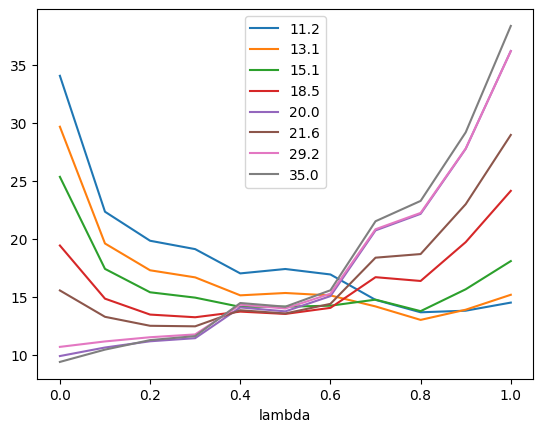

In [18]:
f, ax = plt.subplots()
for diam in sorted(df['effective diameter [cm]'].unique()):
    df[(df.recon!='fbp')&(df['Dose [%]']==25)&(df.recon=='RED-CNN augmented')&(df['effective diameter [cm]']==diam)].plot(x='lambda', y='std [HU]', label=diam,ax=ax)
plt.show()

This plot is really interesting too, in the transition of child sizes (around 19-20 cm) the plot switches from a downward slope with less noise (more performance at higher lambda) to upward slope, so the decision in lambda value really depends on your intended population. For the paper I took the average across pediatric sizes but it could be valuable to show both

In [19]:
df.columns

Index(['effective diameter [cm]', 'FOV [cm]', 'Dose [%]', 'recon', 'lambda',
       'mean [HU]', 'std [HU]'],
      dtype='object')

In [20]:
sorted(df['FOV [cm]'].unique())

[12.0, 14.0, 17.0, 20.0, 24.0, 32.0, 34.0, 39.0]

In [21]:
means = df.groupby(['recon', 'Dose [%]', 'lambda']).mean()
means

effective diameter [cm]  FOV [cm]  mean [HU]  \
recon   Dose [%] lambda                                                 
RED-CNN 25       0.0                     20.4625      24.0  19.245397   
                 0.1                     20.4625      24.0  19.245397   
                 0.2                     20.4625      24.0  19.245398   
                 0.3                     20.4625      24.0  19.245397   
                 0.4                     20.4625      24.0  19.245397   
...                                          ...       ...        ...   
fbp     100      0.6                     20.4625      24.0  23.508144   
                 0.7                     20.4625      24.0  23.508144   
                 0.8                     20.4625      24.0  23.508144   
                 0.9                     20.4625      24.0  23.508144   
                 1.0                     20.4625      24.0  23.508144   

                          std [HU]  
recon   Dose [%] lambda             
RED-CNN 25       0.0     19.245397  
                 0.1     19.245397  
                 0.2     19.245398  
                 0.3     19.245397  
                 0.4     19.245397  
...                            ...  
fbp     100      0.6     23.508144  
                 0.7     23.508144  
                 0.8     23.508144  
                 0.9     23.508144  
                 1.0     23.508144  

[66 rows x 4 columns]

In [22]:
meta[meta.phantom=='uniform'].studyid.unique()

array([ 96,  99, 102, 105, 108, 111, 114, 117, 120, 123, 126, 129, 132,
       135, 138, 141])

In [23]:
meta[meta.phantom=='anthropomorphic'].studyid.unique()

array([142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181])

Let's look at a couple of example images, feel free to change lambda_val to inspect different models (consider preloading a bunch and making this an interactive widget to easily browse models and images)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.06s/it]

(200, 512, 512)


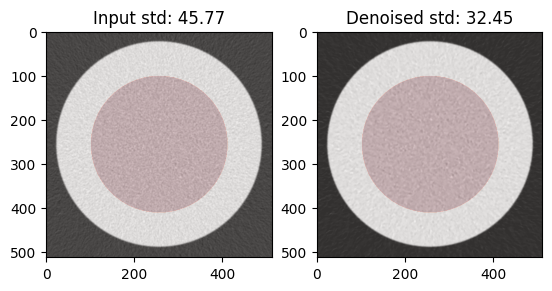

45.59040742937568 32.069252


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.02s/it]

(10, 512, 512)


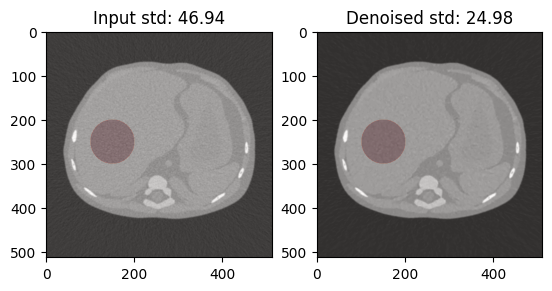

In [24]:
lambda_val = 0
model = load_model(f'models/lambda{int(lambda_val):03d}').to(device)

fname = meta[meta.studyid==96].file 
img = sitk.ReadImage(fname)
vol = sitk.GetArrayFromImage(img)
denoised = model.predict(vol[:20])
print(vol.shape)

r = get_circle_diameter(vol[0])
roi = circle_select(vol[0], (vol[0].shape[0]//2, vol[0].shape[1]//2), r/3)

f, axs = plt.subplots(1, 2)
axs[0].imshow(vol[0], cmap='gray')
axs[0].imshow(roi, cmap='Reds', alpha=0.2)
axs[0].set_title(f'Input std: {vol[0][roi].std():2.2f}')

axs[1].imshow(denoised[0], cmap='gray')
axs[1].imshow(roi, cmap='Reds', alpha=0.2)
axs[1].set_title(f'Denoised std: {denoised[0][roi].std():2.2f}')
plt.show()
print(vol[:,roi].std(axis=1).mean(), denoised[:,roi].std(axis=1).mean())

fname = meta[meta.studyid==142].file 
img = sitk.ReadImage(fname)
vol = sitk.GetArrayFromImage(img)
denoised = model.predict(vol[:20])
print(vol.shape)

r = get_circle_diameter(vol[0])
roi = circle_select(vol[0], (250, 150), 50)

f, axs = plt.subplots(1, 2)
axs[0].imshow(vol[0], cmap='gray')
axs[0].imshow(roi, cmap='Reds', alpha=0.2)
axs[0].set_title(f'Input std: {vol[0][roi].std():2.2f}')

axs[1].imshow(denoised[0], cmap='gray')
axs[1].imshow(roi, cmap='Reds', alpha=0.2)
axs[1].set_title(f'Denoised std: {denoised[0][roi].std():2.2f}')
plt.show()

## Figure 3

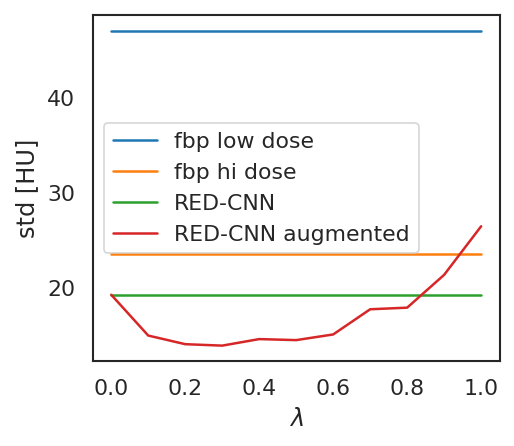

In [25]:
sns.set_context('paper', font_scale=1.2)
sns.set_style('white')
f, ax = plt.subplots(figsize=(3.5, 3), dpi=150)
means['std [HU]']['fbp', 25].plot(ax=ax, label='fbp low dose')
means['std [HU]']['fbp', 100].plot(ax=ax, label='fbp hi dose')
means['std [HU]']['RED-CNN', 25].plot(ax=ax, label='RED-CNN')
means['std [HU]']['RED-CNN augmented', 25].plot(ax=ax, label='RED-CNN augmented')
ax.set_xlabel('$\lambda$')
ax.set_ylabel('std [HU]')
plt.legend()
plt.savefig('figures/fig3_lambda_selection.png', bbox_inches='tight')

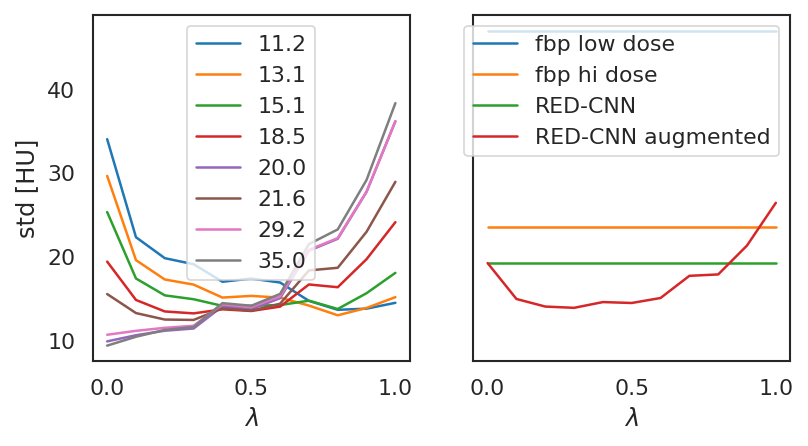

In [26]:
sns.set_context('paper', font_scale=1.2)
sns.set_style('white')

f, axs = plt.subplots(1, 2, figsize=(6, 3), dpi=150, sharex=True, sharey=True)

for diam in sorted(df['effective diameter [cm]'].unique()):
    df[(df.recon!='fbp')&(df['Dose [%]']==25)&(df.recon=='RED-CNN augmented')&(df['effective diameter [cm]']==diam)].plot(x='lambda', y='std [HU]', label=diam,ax=axs[0])
axs[0].set_xlabel('$\lambda$')
axs[0].set_ylabel('std [HU]')

means['std [HU]']['fbp', 25].plot(ax=axs[1], label='fbp low dose')
means['std [HU]']['fbp', 100].plot(ax=axs[1], label='fbp hi dose')
means['std [HU]']['RED-CNN', 25].plot(ax=axs[1], label='RED-CNN')
means['std [HU]']['RED-CNN augmented', 25].plot(ax=axs[1], label='RED-CNN augmented')
axs[1].set_xlabel('$\lambda$')
axs[1].set_ylabel('std [HU]')
plt.legend()

<Axes: xlabel='lambda'>

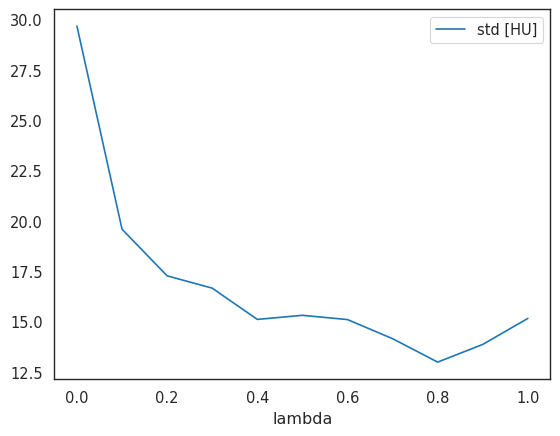

In [27]:
df[(df.recon!='fbp')&(df['Dose [%]']==25)&(df.recon=='RED-CNN augmented')&(df['effective diameter [cm]']==13.1)].plot(x='lambda', y='std [HU]')

<Axes: xlabel='lambda', ylabel='std [HU]'>

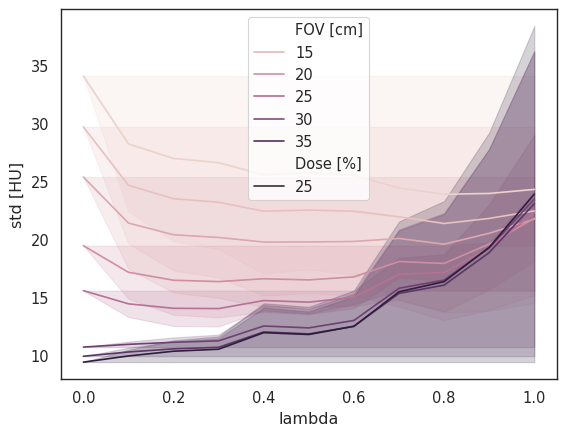

In [28]:
sns.lineplot(data=df[(df.recon!='fbp')&(df['Dose [%]']==25)], x='lambda', y='std [HU]', hue='FOV [cm]', style='Dose [%]')

## Denoise Test Set

idx = 0
for patientid in meta.patientid.unique():
    for didx, dose in enumerate(meta[(meta.patientid == patientid)]['Dose [%]'].unique()):
        meta.loc[(meta.patientid == patientid) & (meta['Dose [%]'] == dose), 'studyid'] = idx
        idx += 1
meta.patientid = meta.patientid.astype(int)
meta.to_csv(peds_datadir / 'metadata.csv', index=False)

In [29]:
meta.studyid.unique()

array([  0,   3,   6,   9,  12,  15,  18,  21,  24,  27,  30,  33,  36,
        39,  42,  45,  48,  51,  54,  57,  60,  63,  66,  69,  72,  75,
        78,  81,  84,  87,  90,  93,  96,  99, 102, 105, 108, 111, 114,
       117, 120, 123, 126, 129, 132, 135, 138, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181])

In [30]:
meta[meta.studyid==3]

,Name,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],...,instance,Unnamed: 0,Code #,gender,weight [kg],height [cm],BMI,weight percentile,ethnicity,simulated
19,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,100.0,fbp,D45,12.3,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,100.0,fbp,D45,12.3,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,100.0,fbp,D45,12.3,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,100.0,fbp,D45,12.3,...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,100.0,fbp,D45,12.3,...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,100.0,fbp,D45,12.3,...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,100.0,fbp,D45,12.3,...,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,100.0,fbp,D45,12.3,...,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,100.0,fbp,D45,12.3,...,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,100.0,fbp,D45,12.3,...,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Use the unique studyids to denoise each patient se

In [31]:
cnn_denoiser = load_model('models/lambda000')
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cpu')

In [32]:
from dataset_utils import itk_to_dicom

In [33]:
def denoise(meta, models:list, model_names:list[str], batch_size=20, device='cpu'):
    if not isinstance(models, list):
        models = [models]
    if not isinstance(model_names, list):
        model_names = [model_names]

    rows = []
    new_studyid = 0
    for studyid in meta.studyid.unique():
        study = meta[meta.studyid==studyid].copy()
        studyname = study.Name.iloc[0] + f" {int(study['Dose [%]'].iloc[0])}% Dose"
        study.studyid = new_studyid
        rows.append(study)
        new_studyid += 1
        input_vol = load_vol(study.file)
        if input_vol.ndim == 3:
            input_vol = input_vol[:, None]
        for model, model_name in zip(models, model_names):
            print(f'{new_studyid} - Denoising: {studyname}: {len(study)} images with {model_name}')
            denoised_vol = model.predict(input_vol, batch_size=batch_size).squeeze()
            img = sitk.GetImageFromArray(denoised_vol)
            pixel_size_mm = study['FOV [cm]'].iloc[0] / denoised_vol.shape[-1] * 10
            img.SetSpacing(3*[pixel_size_mm])
            fnames = itk_to_dicom(img, str(study.file.iloc[0]).replace('fbp', model_name).replace('_000', ''), patientname=study.Name.iloc[0], patientid=study.patientid.iloc[0], age=study['age [year]'].iloc[0],
                                 studyname=studyname, studyid=study.studyid.iloc[0], patient_diameter=study['effective diameter [cm]'].iloc[0],
                                 dose=study['Dose [%]'].iloc[0], kernel=study.kernel.iloc[0], recon=model_name)
            new_study = study.copy()
            new_study.file = fnames
            new_study.recon = model_name
            new_study.studyid = new_studyid
            rows.append(new_study)
            new_studyid += 1
    return pd.concat(rows)

In [34]:
meta.recon.unique()

array(['fbp'], dtype=object)

In [38]:
meta.patientid.unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., nan])

In [40]:
for idx, name in enumerate(meta.Name.unique()):
    meta.loc[meta.Name == name, 'patientid'] = idx
meta.patientid = meta.patientid.astype(int)
meta.patientid.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43])

In [41]:
redcnn_denoiser = load_model('models/lambda000')
redcnn_denoiser_augmented = load_model('models/lambda030')

run_denoising = True

if run_denoising:
    denoised_meta = denoise(meta, models = [redcnn_denoiser, redcnn_denoiser_augmented], model_names=['RED-CNN', 'RED-CNN augmented'], device=dev)
    denoised_meta.to_csv(peds_datadir / 'metadata.csv', index=False)
    denoised_meta

1 - Denoising: 11.2 cm CTP404 25% Dose: 19 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.15s/it]


2 - Denoising: 11.2 cm CTP404 25% Dose: 19 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.40s/it]
/home/brandon.nelson/Dev/PediatricCTSizeAugmentation/.data_aug_torch/lib/python3.11/site-packages/pydicom/valuerep.py:443: UserWarning: The value length (21) exceeds the maximum length of 16 allowed for VR SH.
  warnings.warn(msg)


4 - Denoising: 11.2 cm CTP404 100% Dose: 20 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.01s/it]


5 - Denoising: 11.2 cm CTP404 100% Dose: 20 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.42s/it]


7 - Denoising: 13.1 cm CTP404 25% Dose: 19 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.79s/it]


8 - Denoising: 13.1 cm CTP404 25% Dose: 19 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.82s/it]


10 - Denoising: 13.1 cm CTP404 100% Dose: 20 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.27s/it]


11 - Denoising: 13.1 cm CTP404 100% Dose: 20 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.36s/it]


13 - Denoising: 15.0 cm CTP404 25% Dose: 19 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.24s/it]


14 - Denoising: 15.0 cm CTP404 25% Dose: 19 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.54s/it]


16 - Denoising: 15.0 cm CTP404 100% Dose: 20 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.25s/it]


17 - Denoising: 15.0 cm CTP404 100% Dose: 20 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.15s/it]


19 - Denoising: 15.1 cm CTP404 25% Dose: 19 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.26s/it]


20 - Denoising: 15.1 cm CTP404 25% Dose: 19 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.43s/it]


22 - Denoising: 15.1 cm CTP404 100% Dose: 20 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.87s/it]


23 - Denoising: 15.1 cm CTP404 100% Dose: 20 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.30s/it]


25 - Denoising: 18.5 cm CTP404 25% Dose: 19 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.30s/it]


26 - Denoising: 18.5 cm CTP404 25% Dose: 19 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.44s/it]


28 - Denoising: 18.5 cm CTP404 100% Dose: 20 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.45s/it]


29 - Denoising: 18.5 cm CTP404 100% Dose: 20 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.18s/it]


31 - Denoising: 21.6 cm CTP404 25% Dose: 19 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.36s/it]


32 - Denoising: 21.6 cm CTP404 25% Dose: 19 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.30s/it]


34 - Denoising: 21.6 cm CTP404 100% Dose: 20 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.25s/it]


35 - Denoising: 21.6 cm CTP404 100% Dose: 20 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.23s/it]


37 - Denoising: 29.2 cm CTP404 25% Dose: 19 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.35s/it]


38 - Denoising: 29.2 cm CTP404 25% Dose: 19 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.40s/it]


40 - Denoising: 29.2 cm CTP404 100% Dose: 20 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.37s/it]


41 - Denoising: 29.2 cm CTP404 100% Dose: 20 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.30s/it]


43 - Denoising: 35.0 cm CTP404 25% Dose: 19 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.26s/it]


44 - Denoising: 35.0 cm CTP404 25% Dose: 19 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.37s/it]


46 - Denoising: 35.0 cm CTP404 100% Dose: 20 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.33s/it]


47 - Denoising: 35.0 cm CTP404 100% Dose: 20 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.32s/it]


49 - Denoising: 11.2 cm MITA-LCD 25% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:14<00:00, 19.44s/it]


50 - Denoising: 11.2 cm MITA-LCD 25% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:12<00:00, 19.24s/it]


52 - Denoising: 11.2 cm MITA-LCD 100% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:12<00:00, 19.29s/it]


53 - Denoising: 11.2 cm MITA-LCD 100% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:11<00:00, 19.19s/it]


55 - Denoising: 13.1 cm MITA-LCD 25% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:13<00:00, 19.32s/it]


56 - Denoising: 13.1 cm MITA-LCD 25% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:12<00:00, 19.28s/it]


58 - Denoising: 13.1 cm MITA-LCD 100% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:13<00:00, 19.38s/it]


59 - Denoising: 13.1 cm MITA-LCD 100% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:14<00:00, 19.44s/it]


61 - Denoising: 15.1 cm MITA-LCD 25% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:13<00:00, 19.36s/it]


62 - Denoising: 15.1 cm MITA-LCD 25% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:12<00:00, 19.25s/it]


64 - Denoising: 15.1 cm MITA-LCD 100% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:14<00:00, 19.49s/it]


65 - Denoising: 15.1 cm MITA-LCD 100% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:12<00:00, 19.23s/it]


67 - Denoising: 18.5 cm MITA-LCD 25% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:13<00:00, 19.37s/it]


68 - Denoising: 18.5 cm MITA-LCD 25% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:12<00:00, 19.30s/it]


70 - Denoising: 18.5 cm MITA-LCD 100% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:14<00:00, 19.42s/it]


71 - Denoising: 18.5 cm MITA-LCD 100% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:15<00:00, 19.56s/it]


73 - Denoising: 20.0 cm MITA-LCD 25% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:12<00:00, 19.25s/it]


74 - Denoising: 20.0 cm MITA-LCD 25% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:13<00:00, 19.35s/it]


76 - Denoising: 20.0 cm MITA-LCD 100% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:12<00:00, 19.30s/it]


77 - Denoising: 20.0 cm MITA-LCD 100% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:13<00:00, 19.33s/it]


79 - Denoising: 21.6 cm MITA-LCD 25% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:13<00:00, 19.34s/it]


80 - Denoising: 21.6 cm MITA-LCD 25% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:13<00:00, 19.34s/it]


82 - Denoising: 21.6 cm MITA-LCD 100% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:13<00:00, 19.34s/it]


83 - Denoising: 21.6 cm MITA-LCD 100% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:13<00:00, 19.30s/it]


85 - Denoising: 29.2 cm MITA-LCD 25% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:14<00:00, 19.49s/it]


86 - Denoising: 29.2 cm MITA-LCD 25% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:14<00:00, 19.47s/it]


88 - Denoising: 29.2 cm MITA-LCD 100% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:15<00:00, 19.51s/it]


89 - Denoising: 29.2 cm MITA-LCD 100% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:13<00:00, 19.36s/it]


91 - Denoising: 35.0 cm MITA-LCD 25% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:13<00:00, 19.34s/it]


92 - Denoising: 35.0 cm MITA-LCD 25% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:13<00:00, 19.38s/it]


94 - Denoising: 35.0 cm MITA-LCD 100% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:15<00:00, 19.51s/it]


95 - Denoising: 35.0 cm MITA-LCD 100% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:12<00:00, 19.28s/it]


97 - Denoising: 11.2 cm uniform 25% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:14<00:00, 19.43s/it]


98 - Denoising: 11.2 cm uniform 25% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:14<00:00, 19.49s/it]


100 - Denoising: 11.2 cm uniform 100% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:14<00:00, 19.41s/it]


101 - Denoising: 11.2 cm uniform 100% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:13<00:00, 19.35s/it]


103 - Denoising: 13.1 cm uniform 25% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:14<00:00, 19.49s/it]


104 - Denoising: 13.1 cm uniform 25% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:13<00:00, 19.32s/it]


106 - Denoising: 13.1 cm uniform 100% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:14<00:00, 19.44s/it]


107 - Denoising: 13.1 cm uniform 100% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:20<00:00, 20.07s/it]


109 - Denoising: 15.1 cm uniform 25% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:26<00:00, 20.64s/it]


110 - Denoising: 15.1 cm uniform 25% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:19<00:00, 19.94s/it]


112 - Denoising: 15.1 cm uniform 100% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:16<00:00, 19.68s/it]


113 - Denoising: 15.1 cm uniform 100% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:16<00:00, 19.63s/it]


115 - Denoising: 18.5 cm uniform 25% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:15<00:00, 19.58s/it]


116 - Denoising: 18.5 cm uniform 25% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:16<00:00, 19.61s/it]


118 - Denoising: 18.5 cm uniform 100% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:15<00:00, 19.59s/it]


119 - Denoising: 18.5 cm uniform 100% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:15<00:00, 19.59s/it]


121 - Denoising: 20.0 cm uniform 25% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:16<00:00, 19.60s/it]


122 - Denoising: 20.0 cm uniform 25% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:15<00:00, 19.56s/it]


124 - Denoising: 20.0 cm uniform 100% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:16<00:00, 19.69s/it]


125 - Denoising: 20.0 cm uniform 100% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:15<00:00, 19.56s/it]


127 - Denoising: 21.6 cm uniform 25% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:16<00:00, 19.61s/it]


128 - Denoising: 21.6 cm uniform 25% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:15<00:00, 19.53s/it]


130 - Denoising: 21.6 cm uniform 100% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:15<00:00, 19.53s/it]


131 - Denoising: 21.6 cm uniform 100% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:15<00:00, 19.54s/it]


133 - Denoising: 29.2 cm uniform 25% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:16<00:00, 19.65s/it]


134 - Denoising: 29.2 cm uniform 25% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:15<00:00, 19.54s/it]


136 - Denoising: 29.2 cm uniform 100% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:14<00:00, 19.48s/it]


137 - Denoising: 29.2 cm uniform 100% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:15<00:00, 19.56s/it]


139 - Denoising: 35.0 cm uniform 25% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:16<00:00, 19.61s/it]


140 - Denoising: 35.0 cm uniform 25% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:14<00:00, 19.48s/it]


142 - Denoising: 35.0 cm uniform 100% Dose: 200 images with RED-CNN


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:15<00:00, 19.55s/it]


143 - Denoising: 35.0 cm uniform 100% Dose: 200 images with RED-CNN augmented


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:14<00:00, 19.49s/it]


145 - Denoising: male infant 25% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.00s/it]


146 - Denoising: male infant 25% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.05s/it]


148 - Denoising: male infant 100% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.12s/it]


149 - Denoising: male infant 100% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.30s/it]


151 - Denoising: female 1yr 25% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.03s/it]


152 - Denoising: female 1yr 25% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.99s/it]


154 - Denoising: female 1yr 100% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.03s/it]


155 - Denoising: female 1yr 100% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.98s/it]


157 - Denoising: female pt290 25% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.05s/it]


158 - Denoising: female pt290 25% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00, 10.00s/it]


160 - Denoising: female pt290 100% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.04s/it]


161 - Denoising: female pt290 100% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.15s/it]


163 - Denoising: male pt324 25% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.17s/it]


164 - Denoising: male pt324 25% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.99s/it]


166 - Denoising: male pt324 100% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.08s/it]


167 - Denoising: male pt324 100% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.16s/it]


169 - Denoising: male pt329 25% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.11s/it]


170 - Denoising: male pt329 25% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.97s/it]


172 - Denoising: male pt329 100% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.04s/it]


173 - Denoising: male pt329 100% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.12s/it]


175 - Denoising: female pt336 25% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.00s/it]


176 - Denoising: female pt336 25% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.00s/it]


178 - Denoising: female pt336 100% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.02s/it]


179 - Denoising: female pt336 100% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.06s/it]


181 - Denoising: male 5yr 25% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.02s/it]


182 - Denoising: male 5yr 25% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00, 10.00s/it]


184 - Denoising: male 5yr 100% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.28s/it]


185 - Denoising: male 5yr 100% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.01s/it]


187 - Denoising: female pt328 25% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.12s/it]


188 - Denoising: female pt328 25% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.98s/it]


190 - Denoising: female pt328 100% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.23s/it]


191 - Denoising: female pt328 100% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.06s/it]


193 - Denoising: male pt321 25% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.03s/it]


194 - Denoising: male pt321 25% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.01s/it]


196 - Denoising: male pt321 100% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.03s/it]


197 - Denoising: male pt321 100% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.09s/it]


199 - Denoising: female 10yr 25% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.05s/it]


200 - Denoising: female 10yr 25% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.12s/it]


202 - Denoising: female 10yr 100% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.02s/it]


203 - Denoising: female 10yr 100% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.11s/it]


205 - Denoising: male 15yr 25% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.06s/it]


206 - Denoising: male 15yr 25% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.02s/it]


208 - Denoising: male 15yr 100% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.05s/it]


209 - Denoising: male 15yr 100% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00, 10.00s/it]


211 - Denoising: female 15yr 25% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.02s/it]


212 - Denoising: female 15yr 25% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.02s/it]


214 - Denoising: female 15yr 100% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.16s/it]


215 - Denoising: female 15yr 100% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.08s/it]


217 - Denoising: female pt71 25% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.04s/it]


218 - Denoising: female pt71 25% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.00s/it]


220 - Denoising: female pt71 100% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.05s/it]


221 - Denoising: female pt71 100% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.98s/it]


223 - Denoising: male pt77 25% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.05s/it]


224 - Denoising: male pt77 25% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.02s/it]


226 - Denoising: male pt77 100% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.13s/it]


227 - Denoising: male pt77 100% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.05s/it]


229 - Denoising: female pt152 25% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.11s/it]


230 - Denoising: female pt152 25% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.06s/it]


232 - Denoising: female pt152 100% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.04s/it]


233 - Denoising: female pt152 100% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.01s/it]


235 - Denoising: male pt93 25% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.09s/it]


236 - Denoising: male pt93 25% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.49s/it]


238 - Denoising: male pt93 100% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.06s/it]


239 - Denoising: male pt93 100% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.02s/it]


241 - Denoising: male pt96 25% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.03s/it]


242 - Denoising: male pt96 25% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.18s/it]


244 - Denoising: male pt96 100% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.01s/it]


245 - Denoising: male pt96 100% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.01s/it]


247 - Denoising: male pt148 25% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.02s/it]


248 - Denoising: male pt148 25% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.02s/it]


250 - Denoising: male pt148 100% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.04s/it]


251 - Denoising: male pt148 100% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.23s/it]


253 - Denoising: female pt106 25% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.02s/it]


254 - Denoising: female pt106 25% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.01s/it]


256 - Denoising: female pt106 100% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.03s/it]


257 - Denoising: female pt106 100% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.16s/it]


259 - Denoising: female pt151 25% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.05s/it]


260 - Denoising: female pt151 25% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.08s/it]


262 - Denoising: female pt151 100% Dose: 10 images with RED-CNN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.10s/it]


263 - Denoising: female pt151 100% Dose: 10 images with RED-CNN augmented


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.98s/it]


In [42]:
denoised_meta

,Name,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],...,instance,Unnamed: 0,Code #,gender,weight [kg],height [cm],BMI,weight percentile,ethnicity,simulated
0,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,25.0,fbp,D45,12.30,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,25.0,fbp,D45,12.30,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,25.0,fbp,D45,12.30,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,25.0,fbp,D45,12.30,...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11.2 cm CTP404,11.2,0.083333,newborn,CTP404,Siemens Somatom Definition,25.0,fbp,D45,12.30,...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7107,female pt151,28.1,66.000000,NaN,anthropomorphic,Siemens Definition AS+ (simulated),100.0,RED-CNN augmented,D45,36.53,...,5,395.0,151,F,66.4,162.0,25.301021,48.8,white,True
7108,female pt151,28.1,66.000000,NaN,anthropomorphic,Siemens Definition AS+ (simulated),100.0,RED-CNN augmented,D45,36.53,...,6,396.0,151,F,66.4,162.0,25.301021,48.8,white,True
7109,female pt151,28.1,66.000000,NaN,anthropomorphic,Siemens Definition AS+ (simulated),100.0,RED-CNN augmented,D45,36.53,...,7,397.0,151,F,66.4,162.0,25.301021,48.8,white,True
7110,female pt151,28.1,66.000000,NaN,anthropomorphic,Siemens Definition AS+ (simulated),100.0,RED-CNN augmented,D45,36.53,...,8,398.0,151,F,66.4,162.0,25.301021,48.8,white,True


In [43]:
denoised_meta.to_csv(peds_datadir / 'metadata.csv', index=False)

In [48]:
from utils import study_viewer, browse_studies

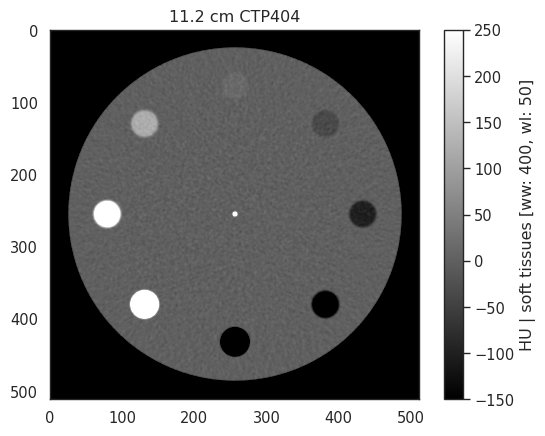

In [70]:
browse_studies(denoised_meta)

In [71]:
study_viewer(denoised_meta)

interactive(children=(Dropdown(description='phantom', options=('CTP404', 'MITA-LCD', 'uniform', 'anthropomorph…